# Implementing a Variational Autoencoder 实现变体自动编码器

### Generative models model a distribution of data over high dimensional space

### 生成模型模拟高维空间数据分布

![Image of Yaktocat](images/gen_models_diag_2.svg)

### Autoencoders are a type of generative model 自编码器是一种生成型号

![Image of Yaktocat](images/deep-style-using-variational-autoencoders-for-image-generation-37-638.jpg?cb=1447260130)



### Problems 问题
- They will overfit unless large training data 
- Gradients diminish quickly so weight updates get progressively smaller the farther we go from the output (vanishing gradient)
+
- 除非大量的训练数据外，他们将会过拟合
- 渐变减慢，所以权重更新越来越小，输出越远（消失的渐变）

### Solution 解决方案
- Add a variational component to regularize training
+
- 添加一个变分组件来规范培训

![Image of Yaktocat](images/vae.4.png)

- VAEs were introduces 3 years ago
- they are built on top of standard function approximators (neural networks), and can be trained with SGD
- simple neural nets can represent a wide variety of interesting functions when given appropriate parameters
- VAE examples 
- pokemon https://github.com/musicmilif/Pokemon-Generator/blob/master/VAE.ipynb
- faces https://github.com/ahmed-touati/vanilla_vae

+

- VAEs是3年前推出的
- 它们建立在标准函数逼近器(神经网络)之上，可以用SGD训练
- 当给定适当的参数时，简单的神经网络可以代表各种有趣的功能
- VAE示例
- pokemon https://github.com/musicmilif/Pokemon-Generator/blob/master/VAE.ipynb
- faces https://github.com/ahmed-touati/vanilla_vae

In [1]:
import numpy as np #matrix math
import tensorflow as tf #machine learning
import matplotlib.pyplot as plt #plotting
%matplotlib inline

# Import MINST data
#The MNIST data is split into three parts: 55,000 data points of training data 
#10,000 points of test data and 5,000 points of validation data 
#very MNIST data point has two parts: an image of a handwritten digit 
#and a corresponding label. 
#We'll call the images "x" and the labels "y". 
#Both the training set and test set contain images and their corresponding labels; 
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
#Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:
n_pixels = 28*28
# Input to the graph -- Tensorflow's MNIST images are (1, 784) vectors
#x isn’t a specific value. 
#It’s a placeholder, a value that we’ll input when we ask TensorFlow 
#to run a computation. We want to be able to input any number of MNIST images, 
#each flattened into a 784-dimensional vector. We represent this as a 2-D tensor of 
#floating-point numbers
X = tf.placeholder(tf.float32, shape=([None, n_pixels]))

In [3]:
#layer creation functions
#we could do this inline but cleaner to wrap it in respective functions

#represent the strength of connections between units.
def weight_variable(shape, name):
    #Outputs random values from a truncated normal distribution.
    #truncated means the value is either bounded below or above (or both)
    initial = tf.truncated_normal(shape, stddev=0.1)
    #A Variable is a modifiable tensor that lives in TensorFlow’s graph of 
    #interacting operations. It can be used and even modified by the computation. 
    #For machine learning applications, one generally has the model parameters 
    #be Variables.
    return tf.Variable(initial, name=name)

#Bias nodes are added to increase the flexibility of 
#the model to fit the data. Specifically, it allows the 
#network to fit the data when all input features are equal to 00, 
#and very likely decreases the bias of the fitted values elsewhere in the data space
def bias_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

#Neurons in a fully connected layer have full connections to 
#all activations in the previous layer, as seen in regular Neural Networks. 
#Their activations can hence be computed with a matrix multiplication followed by a 
#bias offset. 
def FC_layer(X, W, b):
    return tf.matmul(X, W) + b

print("done")

done


## Encoder 编码器
The encoder consists of a 2 layer, fully connected feed forward network that reduces the dimensionality from the original number of features (e.g. pixel) to the dimensionality of the latent space. This network has two outputs -- the mean and (log) standard deviation of a gaussian distribution.

编码器由一个2层全连接的前馈网络组成，可以将原始数量的特征（例如像素）的维数降低到潜在空间的维数。 该网络具有两个输出 - 高斯分布的平均值和（对数）标准偏差。

![Image of Yaktocat](images/1-op0VO_QK4vMtCnXtmigDhA.png)

In [4]:
# encoder
#our VAE model can parse the information spread thinly over the high-dimensional 
#observed world of pixels, and condense the most meaningful features into a 
#structured distribution over reduced (20) latent dimensions
#latent = embedded space, we just see latent used in stochastic models in papers a lot
#latent means not directly observed but are rather inferred
latent_dim = 20
#num neurons
h_dim = 500

#layer 1
W_enc = weight_variable([n_pixels, h_dim], 'W_enc')
b_enc = bias_variable([h_dim], 'b_enc')
# tanh activation function to replicate original model
#The tanh function, a.k.a. hyperbolic tangent function, 
#is a rescaling of the logistic sigmoid, such that its outputs range from -1 to 1.
#tanh or sigmoid? Whatever avoids the vanishing gradient problem!
h_enc = tf.nn.tanh(FC_layer(X, W_enc, b_enc))

#layer 2
W_mu = weight_variable([h_dim, latent_dim], 'W_mu')
b_mu = bias_variable([latent_dim], 'b_mu')
mu = FC_layer(h_enc, W_mu, b_mu) #mean

#instead of the encoder generating a vector of real values, 
#it will generate a vector of means and a vector of standard deviations.
#for reparamterization
W_logstd = weight_variable([h_dim, latent_dim], 'W_logstd')
b_logstd = bias_variable([latent_dim], 'b_logstd')
logstd = FC_layer(h_enc, W_logstd, b_logstd)

# reparameterization trick - lets us backpropagate successfully
#since normally gradient descent expects deterministic nodes
#and we have stochastic nodes
#distribution
noise = tf.random_normal([1, latent_dim])
#sample from the standard deviations (tf.exp computes exponential of x element-wise) 
#and add the mean 
#this is our latent variable we will pass to the decoder
z = mu + tf.multiply(noise, tf.exp(.5*logstd))
#The greater standard deviation on the noise added, 
#the less information we can pass using that one variable.
#The more efficiently we can encode the original image, 
#the higher we can raise the standard deviation on our gaussian until it reaches one.
#This constraint forces the encoder to be very efficient, 
#creating information-rich latent variables. 
#This improves generalization, so latent variables that we either randomly generated, 
#or we got from encoding non-training images, will produce a nicer result when decoded.

print("done")

done


## Decoder 解码器

The decoder (or, in the language of LFADS, the 'generator') is also a feedforward fully connected network -- however, it goes from the dimensionality of the latent space back to the original dimensionality of the data (e.g. pixels). The output of the network is squashed between 0 and 1 with a sigmoid function.

解码器(或者以LFADS的语言，`生成器`）也是前馈的完全连接的网络 - 然而，它从潜在空间的维度返回到数据的原始维数（例如像素）。 网络的输出通过S形功能在0和1之间被压缩。

In [5]:
# decoder

#layer 1
W_dec = weight_variable([latent_dim, h_dim], 'W_dec')
b_dec = bias_variable([h_dim], 'b_dec')
#pass in z here (and the weights and biases we just defined)
h_dec = tf.nn.tanh(FC_layer(z, W_dec, b_dec))


#layer 2, using the original n pixels here since thats the dimensiaonlty
#we want to restore our data to
W_reconstruct = weight_variable([h_dim, n_pixels], 'W_reconstruct')
b_reconstruct = bias_variable([n_pixels], 'b_reconstruct')
#784 bernoulli parameters output
reconstruction = tf.nn.sigmoid(FC_layer(h_dec, W_reconstruct, b_reconstruct))

## Loss function 损失函数
Each of these outputs is taken to be the mean of a Bernoulli distribution (in this example, a Bernoulli distribution is appropriate because our data is binary). The variational lower bound is given by:

这些输出中的每一个都被认为是伯努利分布的平均值（在这个例子中，伯努利分布是适当的，因为我们的数据是二进制的）。 变分下限由下式给出：

\begin{equation}
\mathcal{L} = \mathbb{E}_{z\sim Q(z|X)}\log P(X|z) - D(Q(z|X)||P(z))
\end{equation}

When $P$ is a Bernouli distribution, the log likelihood is given by

当 $P$ 是伯努利分布时，对数似然率由下式给出

\begin{equation}
\log P(X|z) = \sum_i^N X^{(i)}\log y^{(i)} + (1 − X^{(i)}) \cdot \log(1 − y^{(i)})
\end{equation}

where $N$ is the number of training samples (in our case, the batchsize), and $y^{(i)}$ is the reconstruction from the latent code $z^{(i)}$. The KL divergence between a gaussian $Q$ with mean $\mu$ and standard deviation $\sigma$ and a standard normal distribution $P$ is given by:

其中 $N$ 是训练样本的数量（在我们的例子中是batchsize），$y^{(i)}$ 是从潜在代码 $z^{(i)}$ 的重构。 高斯 $Q$ 与平均 $\mu$ 和标准差 $\sigma$ 和标准正态分布 $P$ 之间的KL分歧由下式给出：

\begin{equation}
D(Q||P) = -\frac{1}{2}\sum_j^J \big(1 + \log((\sigma_j)^2) - (\mu_j)^2 - (\sigma_j)^2\big)
\end{equation}

We want to maximize this lower bound, but because tensorflow doesn't have a 'maximizing' optimizer, we minimize the negative lower bound.

我们希望最大化这个下限，但是由于张量流没有“最大化”优化器，我们最小化负下限。

In [6]:
#lets define our loss function

# variational lower bound

# add epsilon to log to prevent numerical overflow
#Information is lost because it goes from a smaller to a larger dimensionality. 
#How much information is lost? We measure this using the reconstruction log-likelihood 
#This measure tells us how effectively the decoder has learned to reconstruct
#an input image x given its latent representation z.
log_likelihood = tf.reduce_sum(X*tf.log(reconstruction + 1e-9)+(1 - X)*tf.log(1 - reconstruction + 1e-9), reduction_indices=1)
#KL Divergence
#If the encoder outputs representations z that are different 
#than those from a standard normal distribution, it will receive 
#a penalty in the loss. This regularizer term means 
#‘keep the representations z of each digit sufficiently diverse’. 
#If we didn’t include the regularizer, the encoder could learn to cheat
#and give each datapoint a representation in a different region of Euclidean space. 
KL_term = -.5*tf.reduce_sum(1 + 2*logstd - tf.pow(mu,2) - tf.exp(2*logstd), reduction_indices=1)

# This allows us to use stochastic gradient descent with respect to the variational parameters
variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
optimizer = tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)

## Training 训练

Now all we have to do is run the optimizer until convergence. 现在我们要做的就是运行优化器直到收敛。

In [7]:
#init all variables and start the session!
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
## Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [8]:
import time #lets clock training time..

num_iterations = 1000000
recording_interval = 1000
#store value for these 3 terms so we can plot them later
variational_lower_bound_array = []
log_likelihood_array = []
KL_term_array = []
iteration_array = [i*recording_interval for i in range(num_iterations//recording_interval)]
for i in range(num_iterations):
    # np.round to make MNIST binary
    #get first batch (200 digits)
    x_batch = np.round(mnist.train.next_batch(200)[0])
    #run our optimizer on our data
    sess.run(optimizer, feed_dict={X: x_batch})
    if (i%recording_interval == 0):
        #every 1K iterations record these values
        vlb_eval = variational_lower_bound.eval(feed_dict={X: x_batch})
        print("Iteration: {}, Loss: {}".format(i, vlb_eval))
        variational_lower_bound_array.append(vlb_eval)
        log_likelihood_array.append(np.mean(log_likelihood.eval(feed_dict={X: x_batch})))
        KL_term_array.append(np.mean(KL_term.eval(feed_dict={X: x_batch})))
        
print("done")

Iteration: 0, Loss: -771.3567504882812
Iteration: 1000, Loss: -690.02001953125
Iteration: 2000, Loss: -639.5819091796875
Iteration: 3000, Loss: -640.6834106445312
Iteration: 4000, Loss: -607.1574096679688
Iteration: 5000, Loss: -606.8295288085938
Iteration: 6000, Loss: -576.7642211914062
Iteration: 7000, Loss: -584.7302856445312
Iteration: 8000, Loss: -557.1863403320312
Iteration: 9000, Loss: -542.4620971679688
Iteration: 10000, Loss: -533.0985107421875
Iteration: 11000, Loss: -503.8031005859375
Iteration: 12000, Loss: -497.09246826171875
Iteration: 13000, Loss: -460.50604248046875
Iteration: 14000, Loss: -455.1629638671875
Iteration: 15000, Loss: -429.13165283203125
Iteration: 16000, Loss: -400.7860412597656
Iteration: 17000, Loss: -387.3765869140625
Iteration: 18000, Loss: -375.55499267578125
Iteration: 19000, Loss: -373.3001403808594
Iteration: 20000, Loss: -351.9190979003906
Iteration: 21000, Loss: -320.2369384765625
Iteration: 22000, Loss: -327.0050354003906
Iteration: 23000, Loss

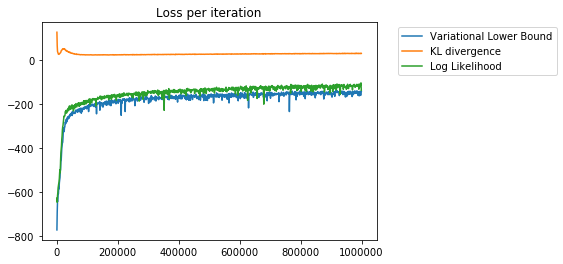

In [9]:
plt.figure()
#for the number of iterations we had 
#plot these 3 terms
plt.plot(iteration_array, variational_lower_bound_array)
plt.plot(iteration_array, KL_term_array)
plt.plot(iteration_array, log_likelihood_array)
plt.legend(['Variational Lower Bound', 'KL divergence', 'Log Likelihood'], bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Loss per iteration')

## Results 结果

Here, we plot the reconstructed image on test set images.

在这里，我们绘制重建图像在测试集图像。

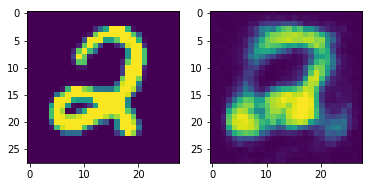

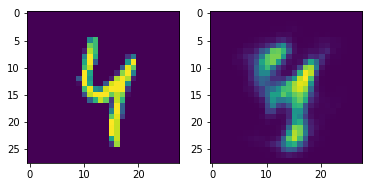

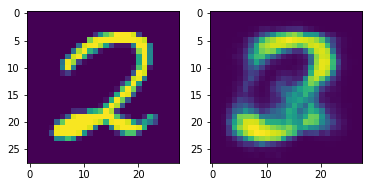

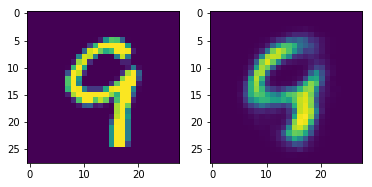

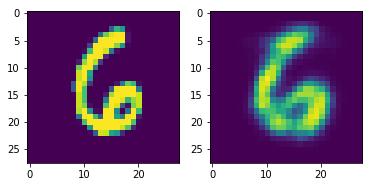

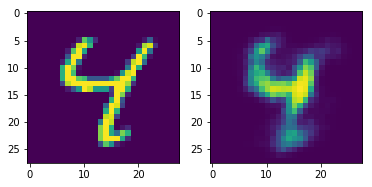

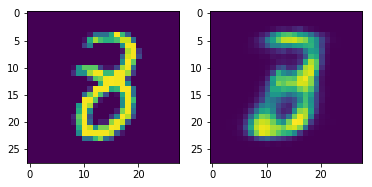

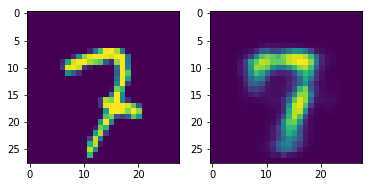

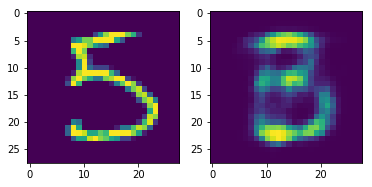

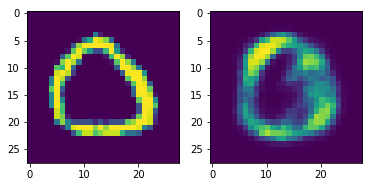

In [10]:
import os
load_model = False
if load_model:
    saver.restore(sess, os.path.join(os.getcwd(), "Trained Bernoulli VAE"))

num_pairs = 10
image_indices = np.random.randint(0, 200, num_pairs)
#Lets plot 10 digits
for pair in range(num_pairs):
    #reshaping to show original test image
    x = np.reshape(mnist.test.images[image_indices[pair]], (1,n_pixels))
    plt.figure()
    x_image = np.reshape(x, (28,28))
    plt.subplot(121)
    plt.imshow(x_image)
    #reconstructed image, feed the test image to the decoder
    x_reconstruction = reconstruction.eval(feed_dict={X: x})
    #reshape it to 28x28 pixels
    x_reconstruction_image = (np.reshape(x_reconstruction, (28,28)))
    #plot it!
    plt.subplot(122)
    plt.imshow(x_reconstruction_image)